In [ ]:
import pandas as pd
import numpy as np

# do a preliminary read of the csv and attempt to parse column types
dev_2017_pre = pd.read_csv('consumption_deviation_FR_new.csv', sep=';', decimal=',', parse_dates=['timestamp'])

print(dev_2017_pre)

# since the quantity column is parsed generically as object, 
# it likely includes some anomalous (e.g. missing) values 
print(dev_2017_pre.dtypes)

In [ ]:
# rows indices 13594, 13595, 13596 are missing values for deviation
print(dev_2017_pre[dev_2017_pre['quantity']=='na'])


In [ ]:
# since only few rows contain missing quantity values, 
# we just load the csv again skipping them
# use 
dev_2017 = pd.read_csv('consumption_deviation_FR_new.csv', sep=';', decimal=',', parse_dates=['timestamp'], skiprows=range(13595,13598))

# check that rows with missing quantity values have been removed
# print(dev_2017[dev_2017['quantity']=='na'])

# another ignored option: filter the loaded dataframe directly.
# however, here we would need to replace commas
# by periods as decimal separators in order to be
# able to parse them as floats

# dev_2017 = dev_2017_pre.loc[dev_2017_pre['quantity']!='na']

In [ ]:
# the column types are now correctly parsed
dev_2017.dtypes

In [ ]:
# there seem to be some extreme outliers
dev_2017.describe()

In [ ]:
# look for the timestamps corresponding to these extremes
dev_2017.set_index('timestamp', inplace=True, drop=True)
dev_2017.loc[dev_2017.idxmin()]

In [ ]:
# the maximum value is not as absurd as the minimum, so no
# need to drop it

dev_2017.loc[dev_2017.idxmax()]

In [ ]:
# the entry corresponding to the minimum value is suspicious
# as there don't exist news of massive energy consumption 
# in france on that date. let's drop it from the dataframe

# i should drop outliers more systematically, like with a 
# lambda function
dev_2017.drop(dev_2017.idxmin(), inplace=True)


In [ ]:
# the new minimum is also suspicious, let's drop it as well
dev_2017.loc[dev_2017.idxmin()]

In [ ]:
dev_2017.drop(dev_2017.idxmin(), inplace=True)

In [ ]:
# the resulting minimum seems more realistic, so we'll keep it

dev_2017.loc[dev_2017.idxmin()]

In [ ]:
# now let's have a look at the time series. it would be
# unintelligible if we hadn't removed the outliers
dev_2017.plot()

In [ ]:
# since we are interested in the relation between average 
# consumption and average temperature on a half-hourly basis,
# aggregate the consumption data. this will only affect the 
# rows for the last day of the year, which have a quarter-hourly 
# granularity as opposed to the half-hourly of the remaining
# rows, and will re-introduce the rows we excluded earlier
# for being outliers, now with value NaN, so we should look out
dev_2017_half = dev_2017.resample('30T').mean()
dev_2017_half.tail(10)

In [ ]:
dev_2017_half.loc['2017-11-05']

In [ ]:
dev_2017_half.plot()

In [ ]:
dev_2017_half.index

In [ ]:
# let us now data corresponding to temperatures
# first i will restrict to data from a station 
# close to paris, named LFPB

paris_temp_2017_pre = pd.read_csv('LFPB.txt', skiprows=5, parse_dates=True, usecols=['valid', 'tmpc'], index_col='valid')

In [ ]:
paris_temp_2017_pre.head(10)

In [ ]:
paris_temp_2017_pre.dtypes

In [ ]:
paris_temp_2017_pre.index

In [ ]:
# since we are interested in consumption data on a half-hourly
# basis, we need to make sure this is the granularity of the
# temperature data as well. for this, we can fill missing values
# values via forward fill, as we don't expect much temperature
# variation on short time intervals

paris_temp_2017 = paris_temp_2017_pre.resample('30T').ffill()



In [ ]:
paris_temp_2017

In [ ]:
# let's do the same with the historical temperature data from
# the same weather station near paris, which comprises measurements
# from 2010 to 2016

paris_temp_hist_pre = pd.read_csv('LFPB_historical.txt', skiprows=5, parse_dates=True, usecols=['valid', 'tmpc'], index_col='valid')

In [ ]:
paris_temp_hist_pre.head(10)

In [ ]:
# uniformize the granularity of this dataset
# here asfreq or resample don't work because it says there are 
# nonunique index values

# this is because apparently index_cols doesn't check 
# for uniqueness of index values, as illustrated below

paris_temp_hist = paris_temp_hist_pre.resample('30T').ffill()

In [ ]:
paris_temp_hist_pre[paris_temp_hist_pre.index.duplicated()]

In [ ]:
paris_temp_hist_pre.loc['2010-03-28 22:00:00']

In [ ]:
# let's re-read the csv without setting the index column,
# setting the index after removing duplicate timestamps
paris_temp_hist_pre = pd.read_csv('LFPB_historical.txt', skiprows=5, parse_dates=['valid'], usecols=['valid', 'tmpc']).drop_duplicates('valid', keep='first').set_index('valid')

In [ ]:
paris_temp_hist_pre.index

In [ ]:
paris_temp_hist_pre

In [ ]:
# now we can make sure the granularity is 30 minutes

paris_temp_hist = paris_temp_hist_pre.resample('30T').ffill()

In [ ]:
paris_temp_hist.index

In [ ]:
# we will start by generating an average value of the temperature
# for every half-hour of the year

paris_temp_avg = paris_temp_hist['tmpc'].groupby([paris_temp_hist.index.month, 
                                         paris_temp_hist.index.day, 
                                         paris_temp_hist.index.hour, 
                                         paris_temp_hist.index.minute]).agg([np.mean, np.std])

In [ ]:
# this dataframe contains a bit too many half-hours because the year
# range comprises the leap years 2012 and 2016. since 2017 is not leap,
# we should exclude the leap days 
# (optimally, do the comparison based on whether the year to predict
# consumption for is leap or not)
paris_temp_avg

In [ ]:
# for the purpose of this draft, on the context of 2017, we force
# the granularity once more, this time filtering out the leap days

paris_temp_hist_leap = paris_temp_hist_pre.resample('30T').ffill()
paris_temp_hist=paris_temp_hist_leap.loc[~((paris_temp_hist_leap.index.month==2) & (paris_temp_hist_leap.index.day==29))]

# maybe it's not allowed to filter out entries at this point since 
# the index has an associated frequency

# turns out you can filter it like this. in the boolean mask i was using
# paris_temp_hist_pre instead of paris_temp_hist_leap 

In [ ]:
paris_temp_hist

In [ ]:
# and lets aggregate on a half-hour basis, ignoring year,
# once more, to check that excluding the leap day gives
# the correct number of halfhours in a year

# this doesn't work either for the same reason as above

# turns out this does work!

paris_temp_avg = paris_temp_hist.loc[~((paris_temp_hist.index.month==2) & (paris_temp_hist.index.day==29))].groupby([paris_temp_hist.index.month, 
                                         paris_temp_hist.index.day, 
                                         paris_temp_hist.index.hour, 
                                         paris_temp_hist.index.minute]).mean()

In [ ]:
paris_temp_avg

In [ ]:
# the leap years can only be filtered at this point

paris_temp_avg_noleap = paris_temp_avg.loc[~((paris_temp_avg.index.get_level_values(0)==2) & (paris_temp_avg.index.get_level_values(1)==29))]

In [ ]:
[paris_temp_avg_noleap['year'],paris_temp_avg_noleap['month'],paris_temp_avg_noleap['day'],paris_temp_avg_noleap['hour'],paris_temp_avg_noleap['minute']]=[2017]+[paris_temp_avg_noleap.index.get_level_values(i) for i in range(4)]

In [ ]:
# aggregating data using multiindex groupby is troublesome,
# maybe it's better to do it this way

current_year = '2017'
paris_temp_hist['time_of_year']=pd.to_datetime(paris_temp_hist.index.strftime(current_year+'-%m-%d %H:%M:%S'))

In [ ]:
paris_temp_hist

In [ ]:
paris_temp_avg = paris_temp_hist.groupby(['time_of_year']).agg([np.mean, np.std])

In [ ]:
paris_temp_avg

In [ ]:
paris_temp_avg.index

In [ ]:
# another option would be to create a dataframe with columns 
# indexed by year. Here I would need to come up with a way to
# line up the leap days. Will keep it in MIND!!!

In [ ]:
# measurements corresponding to dec 31st are missing, so we
# will enlarge the index and fill with the temperatures from
# dec 30th
paris_temp_2017.index

In [ ]:
complete_2017 = pd.date_range('2017-01-01 00:00:00', '2017-12-31 23:30:00', freq='30T')

In [ ]:
complete_2017

In [ ]:
paris_temp_2017_complete = paris_temp_2017.reindex(complete_2017)

In [ ]:
paris_temp_2017_complete['2017-12-31']=paris_temp_2017_complete['2017-12-30'].values

In [ ]:
paris_temp_2017_complete['2017-12-31']

In [ ]:
paris_temp = paris_temp_2017_complete.join(paris_temp_avg['tmpc']['mean'])

In [ ]:
paris_temp['deviation']=paris_temp['tmpc']-paris_temp['mean']

In [ ]:
paris_temp

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(paris_temp['deviation'], dev_2017_half['quantity'], s=5, c=paris_temp.index.month, marker='.')

In [ ]:
[paris_temp.loc['2017-'+str(i),'deviation'].corr(dev_2017_half.loc['2017-'+str(i),'quantity']) for i in range(1,13)]

In [ ]:
paris_temp.describe()


In [ ]:
paris_temp.loc[paris_temp['deviation'].idxmax()]

In [ ]:
paris_temp.loc[paris_temp['deviation'].idxmin()]

In [ ]:
paris_temp['deviation'].hist(bins=100)

In [ ]:
dev_2017_half['quantity'].hist(bins=100)

# Now let's load all the data, historical and 2017, in a single dataframe that we will pivot to get columns of temperature by year and weather station 

We will now load temperature records from 2006 to 2017 as measured by six weather stations, located near six cities. These cities are among the ten most populated cities in France, and are chosen to lie geographically distributed in France (only by eye). The weather station names and the corresponding cities are listed below:
- LFBO: Toulousse
- LFLY: Lyon
- LFML: Marseille
- LFPB: Paris
- LFRS: Nantes
- LFQQ: Lille

*Caution: I just realized that the timestamps of these measurements are given in UTC, whereas the consumption deviation ones are likely given in France local time*


In [ ]:
temperature_all_pre = pd.read_csv('asos_six_cities.txt', sep=',', header=0, names=['station', 'timestamp', 'temperature'], parse_dates=['timestamp'], index_col=['timestamp', 'station'])

In [ ]:
temperature_all_pre

In [ ]:
temperature_all_pre.dtypes

In [ ]:
temperature_all_pre.index.get_level_values(0)

In [ ]:
# apparently there are no missing temperature values. 

temperature_all_pre[temperature_all_pre['temperature']=='null']

In [ ]:
temperature_all_pre.unstack(level=0)

In [ ]:
# apparently there are duplicate indices. let's check which ones

temperature_all_pre[temperature_all_pre.index.duplicated(keep=False)].head(50)

In [ ]:
temperature_all_unique = temperature_all_pre[~temperature_all_pre.index.duplicated(keep='first')]

In [ ]:
temperature_all_unique.head(50)

In [ ]:
# since early records are missing substantial data, let's 
# pass the starting year for the analysis as a variable

starting_year = '2008'

temperature_all_stations = temperature_all_unique.unstack()[starting_year:]

In [ ]:
# check the percentage of missing measurements

df=temperature_all_stations
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
print(missing_value_df)

In [ ]:
# flatten the column multi-index. now the columns are labelled 
# by the name of the station. as before, the values are the
# (backfilled) temperature of the named station at the given 
# timestamp


temperature_all_stations.columns = temperature_all_stations.columns.get_level_values(1)

In [ ]:
# complete the index to encompass all half-hours in the given period
# leaving missing values to be interpolated subsequently

temperature_all_stations_full_range = temperature_all_stations.asfreq('30T')

In [ ]:
temperature_all_stations_full_range

In [ ]:
temperature_all_stations_filled = temperature_all_stations_full_range.interpolate()

In [ ]:
# for some reason, the last measurement on 2017 is on dec 30th
# let's enlarge the index by the last day of 2017 and reproduce
# the same temperatures as those of the 30th

last_day = pd.date_range(start='2017-12-31', freq='30T', periods=48)
complete_index = temperature_all_stations_filled.index.union(last_day)
temperature_all_stations_complete = temperature_all_stations_filled.reindex(complete_index)
temperature_all_stations_complete['2017-12-31'] = temperature_all_stations_complete['2017-12-30'].values

In [ ]:
temperature_all_stations_complete['time_of_year'] = temperature_all_stations_complete.index.strftime('%m-%d %H:%M:%S')

In [ ]:
temperature_all_stations_complete['stationwise-mean'],temperature_all_stations_complete['stationwise-std'] = temperature_all_stations_complete.mean(axis=1), temperature_all_stations_complete.std(axis=1)

In [ ]:
temperature_all_stations_complete

In [ ]:
temperature_all_stations_complete.groupby('time_of_year').mean()

In [ ]:
temp_2017 = temperature_all_stations_complete['2017'][['stationwise-mean']]

In [ ]:
temp_2017


In [ ]:
temp_hist = (temperature_all_stations_complete[:'2016'][['stationwise-mean', 'time_of_year']]
             .groupby('time_of_year')
             .mean())

In [ ]:
temp_hist_noleap = temp_hist[~temp_hist.index.str.contains('02-29', regex=False)]

In [ ]:
temp_hist

In [ ]:
temp_hist_noleap['not_a_timestamp'] = pd.to_datetime('2017-'+temp_hist_noleap.index)

In [ ]:
temp_hist_noleap.set_index('not_a_timestamp', inplace=True, drop=True)

In [ ]:
temp_hist_noleap

In [ ]:
temp_hist_noleap.index

In [ ]:
temp_2017['deviation']=temp_2017['stationwise-mean']-temp_hist_noleap['stationwise-mean']

In [ ]:
temp_2017


In [ ]:
plt.scatter(temp_2017['deviation'], dev_2017_half['quantity'], s=5, c=paris_temp.index.month, marker='.')

In [ ]:
plt.scatter(paris_temp['deviation'], dev_2017_half['quantity'], s=5, c=paris_temp.index.month, marker='.')

In [ ]:
[paris_temp.loc['2017-'+str(i),'deviation'].corr(dev_2017_half.loc['2017-'+str(i),'quantity']) for i in range(1,13)]

In [ ]:
[temp_2017.loc['2017-'+str(i),'deviation'].corr(dev_2017_half.loc['2017-'+str(i),'quantity']) for i in range(1,13)]

In [ ]:
temp_2017

In [ ]:
# let's categorize dates according to meteorological season.
# these differ from the astronomical seasons in that they 
# begin with the month and exhibit the hottest (in summer)
# and the coldest (in winter) quarters of the year

def get_season(timestamp):
    
    spring = range(3,6)
    summer = range(6,9)
    autumn = range(9,12)
        
    if timestamp.month in spring: return 'spring'
    elif timestamp.month in summer: return 'summer'
    elif timestamp.month in autumn: return 'autumn'
    else: return 'winter'
    
    

In [ ]:
temp_2017['season'] = temp_2017.index.map(get_season)

In [ ]:
temp_2017['2017-04']

In [ ]:
temp_2017[temp_2017['season']=='summer']

In [ ]:
plt.scatter(temp_2017[temp_2017.index.map(get_season)=='summer']['deviation'], dev_2017_half[dev_2017_half.index.map(get_season)=='summer']['quantity'], s=5, marker='.')

In [ ]:
plt.scatter(temp_2017[temp_2017.index.map(get_season)=='winter']['deviation'], dev_2017_half[dev_2017_half.index.map(get_season)=='winter']['quantity'], s=5, marker='.')

# TASK: Temperature and forecast deviations


In this task, we are provided a time series representing the physical deficit or surplus of electricity consumption in France during the year **2017**. This data exhibits the uncertainty in the prediction of electricity production and consumption by actors in the french electricity market. Since such deviations from actual consumption entail costs for market actors, it is important to aim at minimizing them, using whichever data available.

Temperature forecasts can be used as a basic indicator for deviations of energy consumption. Indeed, since usage of heating or air-conditioning is influenced by air temperature, utilities partly base their consumption forecast for a time period on a temperature forecast, especially during winter and summer. Thus, actual electricity consumption may be larger than anticipated if a summer is hotter or a winter is colder than expected. 

- [ ] State the language and the libraries that will be used for the analysis, and load them here.

In [34]:
import pandas as pd
import numpy as np
from scipy import stats


## Electricity consumption data

We start by loading the time series of consumption deviation in France. 

In [89]:
dev_2017_pre = pd.read_csv('consumption_deviation_FR_new.csv', sep=';', decimal=',', parse_dates=['timestamp'])

The time seriers contains deviation records for every half-hour in the year 2017 (with the exception of December 31st, where the granularity is quarter-hourly)

In [90]:
dev_2017_pre

,timestamp,quantity
0,2017-01-01 00:00:00,"-44,875"
1,2017-01-01 00:30:00,"-18,125"
2,2017-01-01 01:00:00,"-10,375"
3,2017-01-01 01:30:00,"7,125"
4,2017-01-01 02:00:00,"-43,375"
...,...,...
17535,2017-12-31 22:45:00,"-21,48982889"
17536,2017-12-31 23:00:00,"-7,807809406"
17537,2017-12-31 23:15:00,"-56,69726053"
17538,2017-12-31 23:30:00,"21,83256871"


### Parsing data

Since pandas is not parsing the column 'quantity' as a float, there must be values that don't correspond to numbers.

In [91]:
print(dev_2017_pre.dtypes)

# coerce sets unparsed values as NaN

dev_2017_pre['quantity'] = pd.to_numeric(dev_2017_pre['quantity'].str.replace(',','.'), errors='coerce')

timestamp    datetime64[ns]
quantity             object
dtype: object


There are just three consecutive missing quantity values. Since deviation data is rather discontinuous, we will these entries unspecified for the moment.

In [92]:
dev_2017_pre[dev_2017_pre['quantity'].isnull()]

,timestamp,quantity
13594,2017-11-10 16:00:00,NaN
13595,2017-11-10 16:30:00,NaN
13596,2017-11-10 17:00:00,NaN


### Removing outliers

Notice below that the mean and the median differ a lot. This indicates that the time series contains some extreme outliers which we need to take care of.

In [50]:
dev_2017_pre.describe()

,quantity
count,1.753700e+04
mean,-7.852510e+03
std,7.435333e+05
min,-7.898546e+07
25%,-3.087500e+01
50%,2.875000e+00
75%,3.875000e+01
max,5.651250e+02


This is evident in a plot of the time series. To plot it let's first set the timestamp as the index of the dataframe.

<AxesSubplot:xlabel='timestamp'>

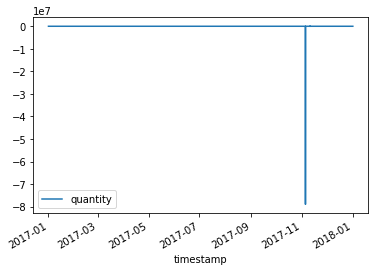

In [93]:
dev_2017_pre.set_index('timestamp', inplace=True, drop=True)
dev_2017_pre.plot()

The outliers seem very scarce. A reasonable way to remove them is using *z-scores*. The z-score of a data point measures how far it lies from the mean value, relative to the standard deviation (dispersion of the data). Here we retain data points that lie within three standard deviations of the mean. This will also remove the three consecutive `NaN` values from above.

<AxesSubplot:xlabel='timestamp'>

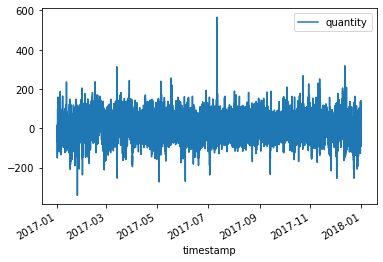

In [84]:
dev_2017 = dev_2017_pre.loc[(np.abs(stats.zscore(dev_2017_pre, nan_policy='omit'))<3)]
dev_2017.plot()

### Setting data resolution

The task requires to compare consumption and temperature deviations on a daily basis. This is reasonable, since a finer resolution of half-hourly records of consumption deviation has a large variability.

The next step is therefore to aggregate data on a daily basis, computing the mean deviation

In [94]:
dev_2017_daily = dev_2017.resample('D').mean()

Note that the dataframe obtained contains 365 rows, so it's complete. With the coarser resolution we have also addressed the issue of removed data (either for being `NaN` or for being outliers).

In [95]:
dev_2017_daily

,quantity
timestamp,
2017-01-01,-25.520833
2017-01-02,98.132812
2017-01-03,-36.273438
2017-01-04,34.421875
2017-01-05,25.817708
...,...
2017-12-27,-80.122396
2017-12-28,-33.854167
2017-12-29,5.757812


Since we are required to estimate the probability of deficit or surplus in the electrical grid, we add a corresponding categorical value to the dataframe. Its value is one if there is a surplus (or a perfect balance) and zero if there is a deficit.

In [114]:
def surplus(x): return int((np.sign(x)+1)/2)

dev_2017_daily['surplus'] = dev_2017_daily['quantity'].map(surplus).astype('category')

In [115]:
dev_2017_daily

,quantity,surplus
timestamp,,
2017-01-01,-25.520833,0
2017-01-02,98.132812,1
2017-01-03,-36.273438,0
2017-01-04,34.421875,1
2017-01-05,25.817708,1
...,...,...
2017-12-27,-80.122396,0
2017-12-28,-33.854167,0
2017-12-29,5.757812,1


## Temperature data